In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt


In [57]:
# Load dataset
df = pd.read_excel('data/final_labels_SG2.xlsx')

In [58]:
df.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3674 entries, 0 to 3673
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           3674 non-null   object
 1   outlet         3674 non-null   object
 2   topic          3674 non-null   object
 3   type           2674 non-null   object
 4   label_bias     3674 non-null   object
 5   label_opinion  3674 non-null   object
 6   biased_words   3674 non-null   object
dtypes: object(7)
memory usage: 201.1+ KB


In [59]:
# Quitar news_link, ya que no nos proporciona información util para el modelo
df.drop('news_link', axis=1, inplace=True)


In [60]:
df.head()

,text,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is r...",Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently sa...",Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all o...",MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,...we sounded the alarm in the early months of...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,[Black Lives Matter] is essentially a non-fals...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3674 entries, 0 to 3673
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           3674 non-null   object
 1   outlet         3674 non-null   object
 2   topic          3674 non-null   object
 3   type           2674 non-null   object
 4   label_bias     3674 non-null   object
 5   label_opinion  3674 non-null   object
 6   biased_words   3674 non-null   object
dtypes: object(7)
memory usage: 201.1+ KB


In [62]:
df.isna().sum()

text                0
outlet              0
topic               0
type             1000
label_bias          0
label_opinion       0
biased_words        0
dtype: int64

<Axes: xlabel='type'>

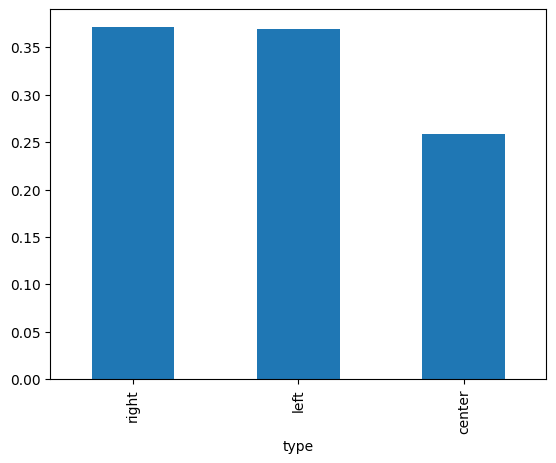

In [63]:
df.type.value_counts(normalize=True).plot(kind='bar')

In [66]:
import pandas as pd

def dataset_overview(df):
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"Total Missing Values: {df.isnull().sum().sum()}")
    print(f"Total Duplicates: {df.duplicated().sum()}")
    print("="*50)

dataset_overview(df)


Dataset Overview:
Shape: (3674, 7)
Total Missing Values: 1000
Total Duplicates: 0


In [67]:
def column_summary(df):
    summary = pd.DataFrame({
        "Data Type": df.dtypes,
        "Unique Values": df.nunique(),
        "Missing Values": df.isnull().sum(),
        "Missing (%)": df.isnull().mean() * 100
    })
    print("Column Summary:")
    display(summary)  # Use print(summary) if not in Jupyter
    print("="*50)

column_summary(df)


Column Summary:


,Data Type,Unique Values,Missing Values,Missing (%)
text,object,3674,0,0.000000
outlet,object,11,0,0.000000
topic,object,23,0,0.000000
type,object,3,1000,27.218291
label_bias,object,3,0,0.000000
label_opinion,object,4,0,0.000000
biased_words,object,1623,0,0.000000


In [71]:
def descriptive_statistics(df):
    print("Features:")
    display(df.describe())  # For numerical columns

descriptive_statistics(df)


Features:


,text,outlet,topic,type,label_bias,label_opinion,biased_words
count,3674,3674,3674,2674,3674,3674,3674
unique,3674,11,23,3,3,4,1623
top,"""Orange Is the New Black"" star Yael Stone is r...",Breitbart,marriage-equality,right,Non-biased,Entirely factual,[]
freq,1,943,347,993,1863,1600,1825


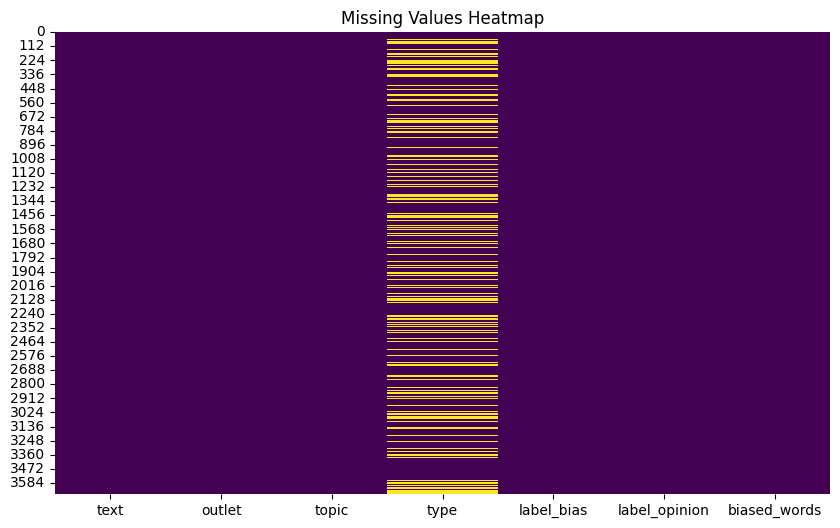

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

def missing_values_heatmap(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cmap="viridis", cbar=False)
    plt.title("Missing Values Heatmap")
    plt.show()

missing_values_heatmap(df)


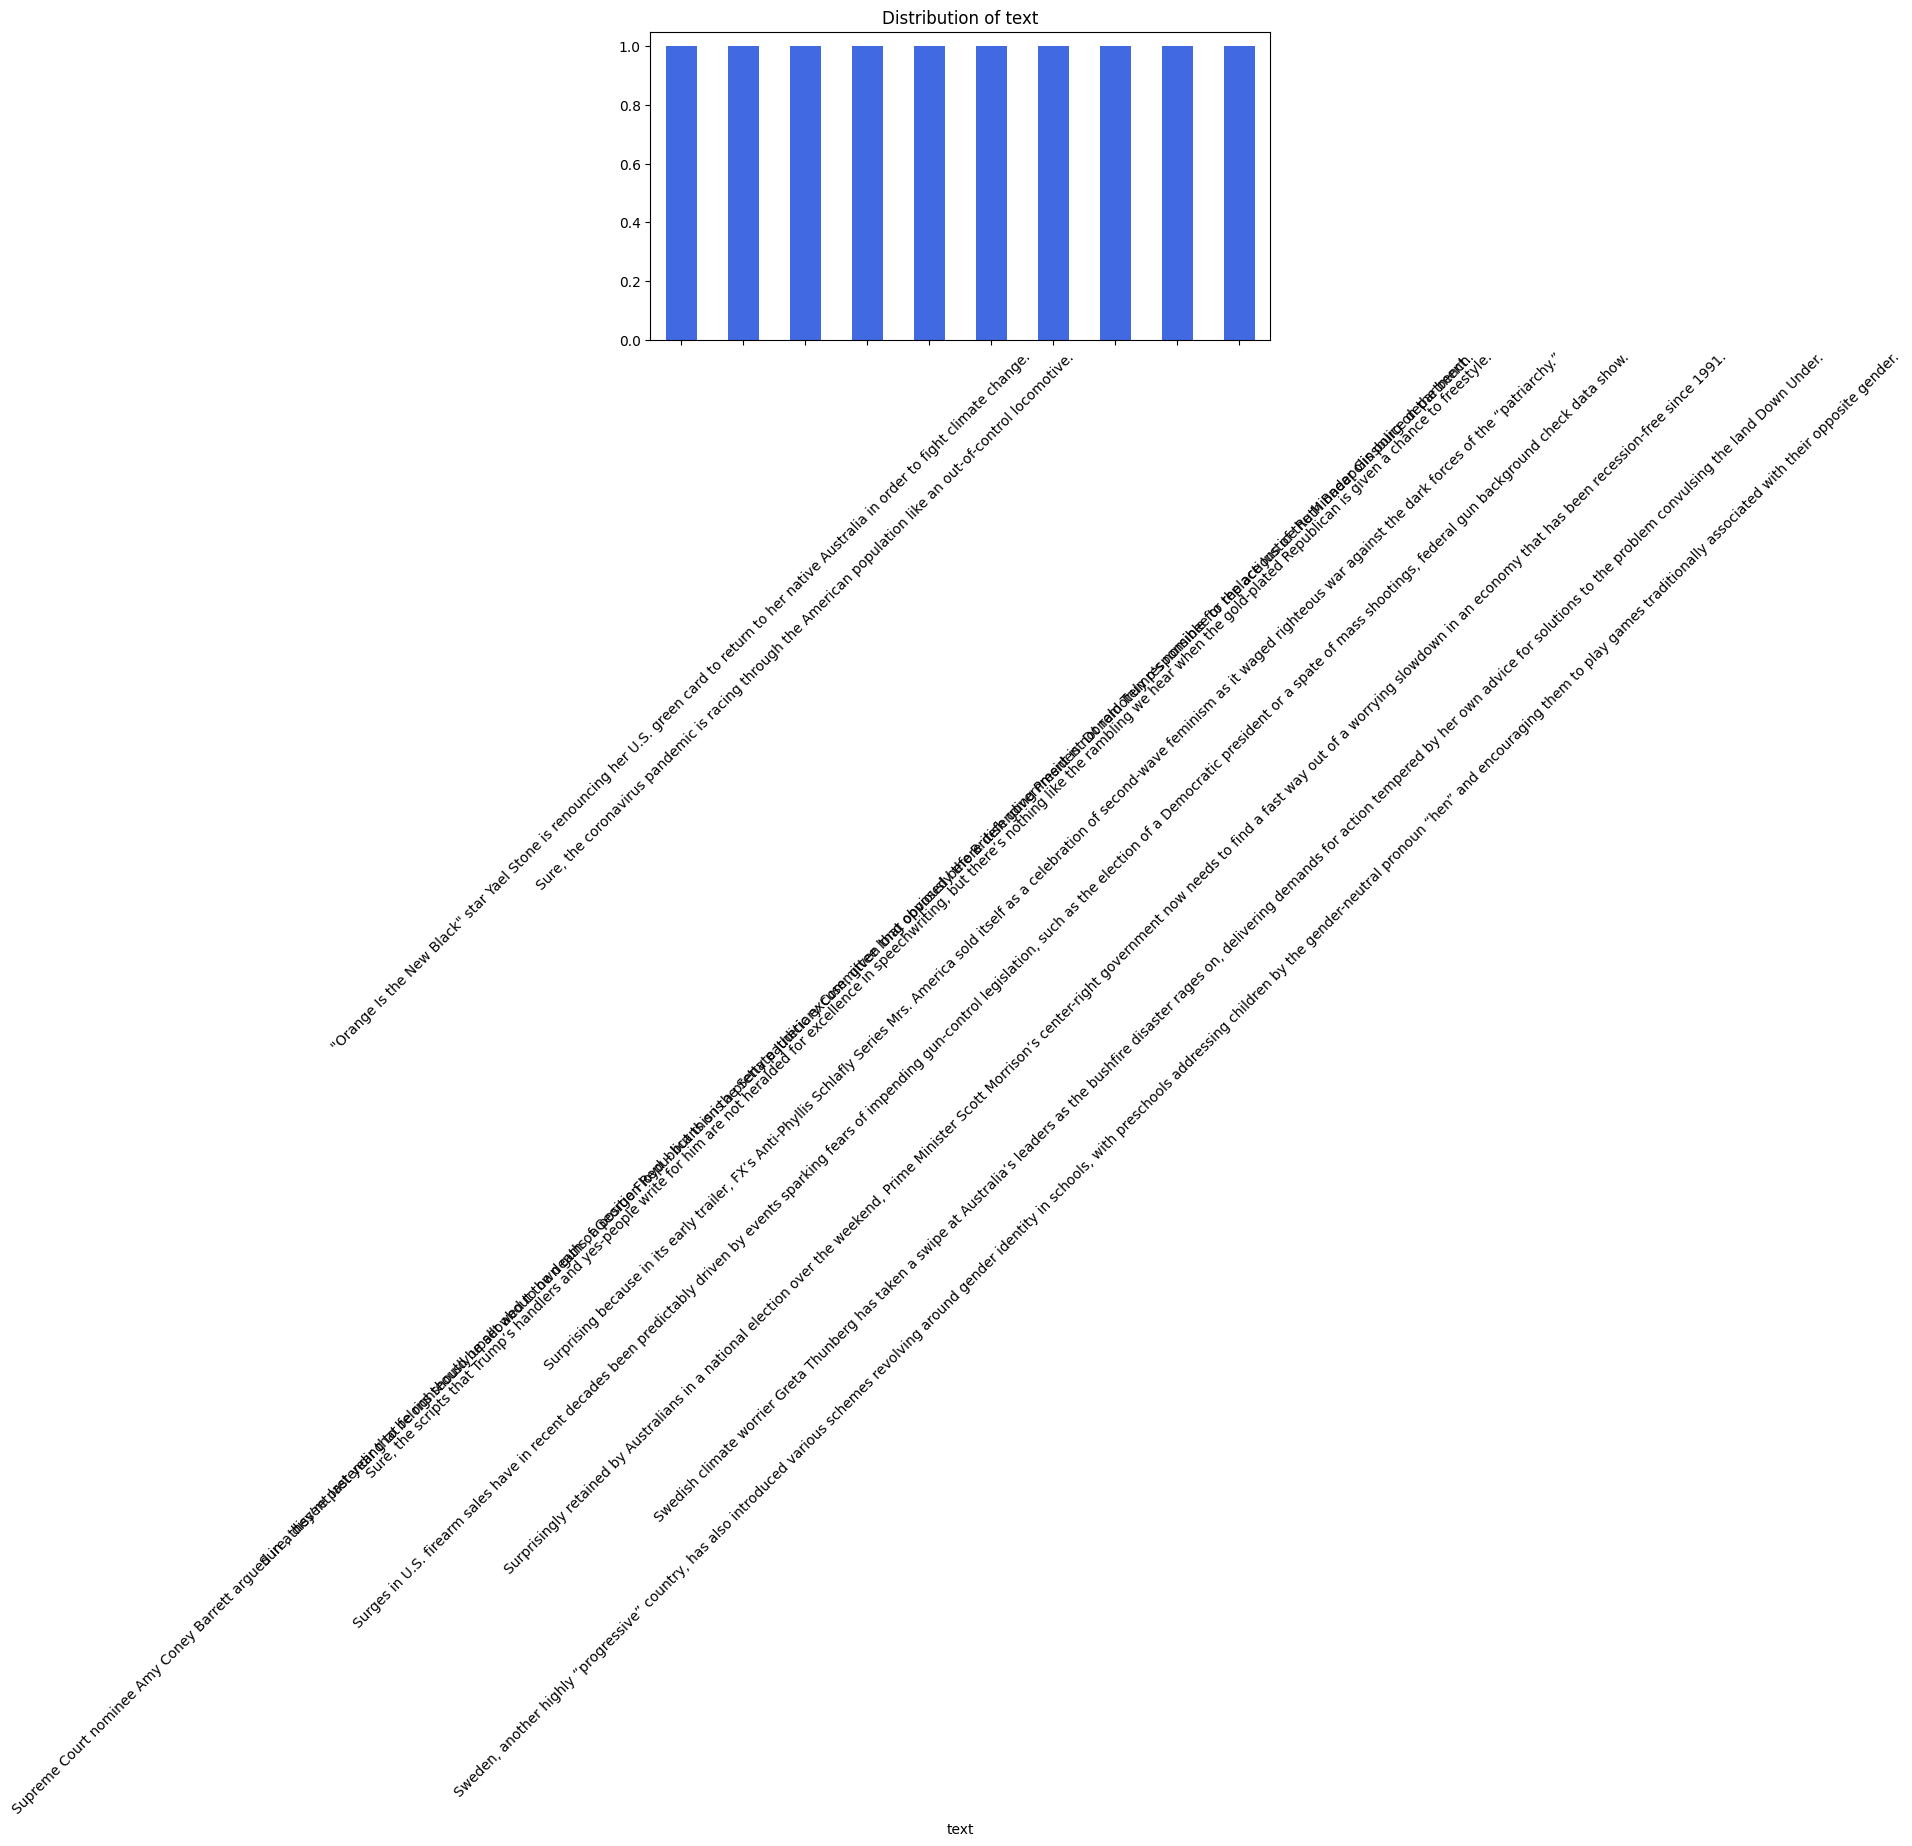

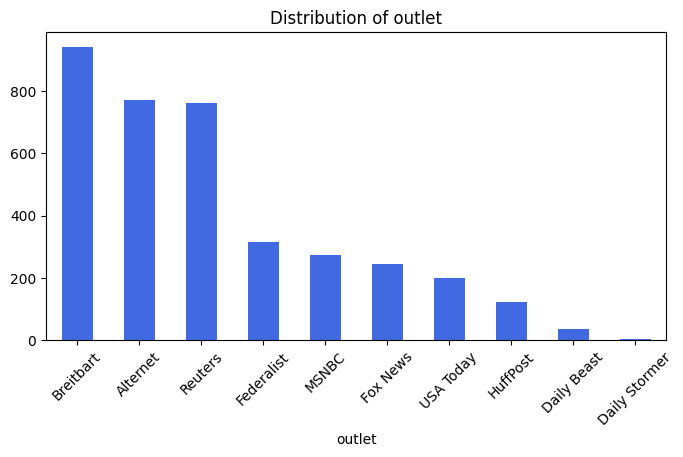

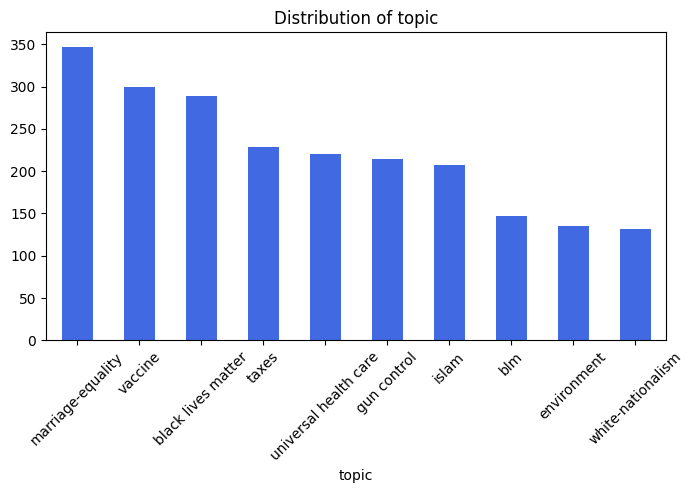

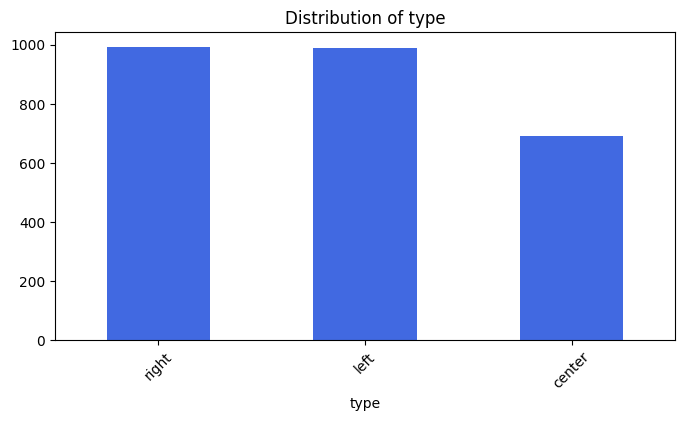

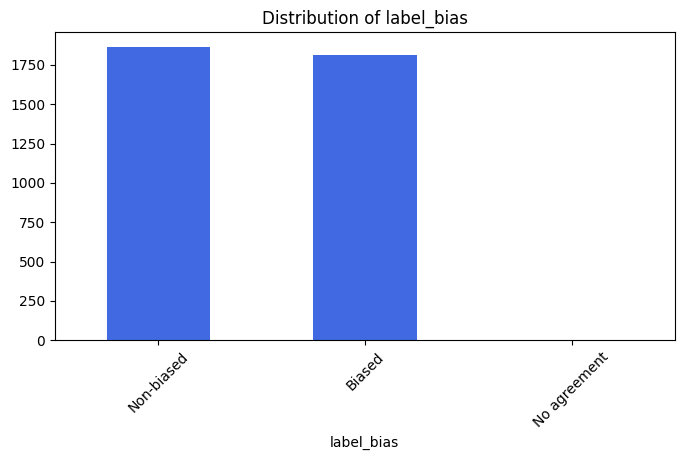

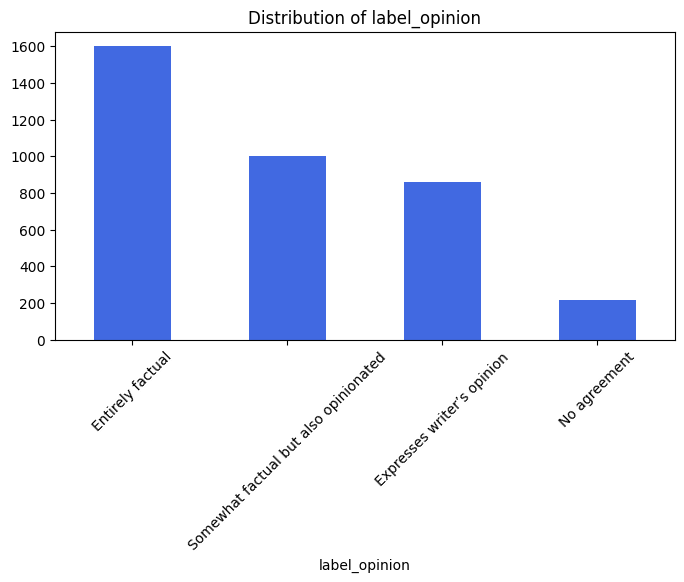

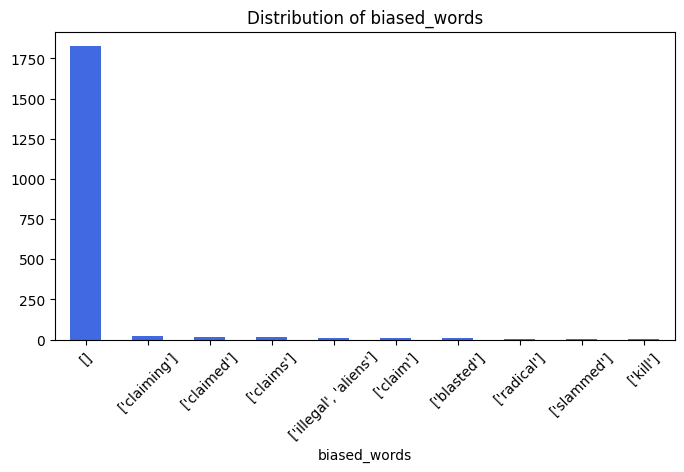

In [77]:
def plot_categorical_bars(df, max_categories=10):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    for col in categorical_cols:
        plt.figure(figsize=(8, 4))
        df[col].value_counts().nlargest(max_categories).plot(kind="bar", color="royalblue")
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.show()

plot_categorical_bars(df)


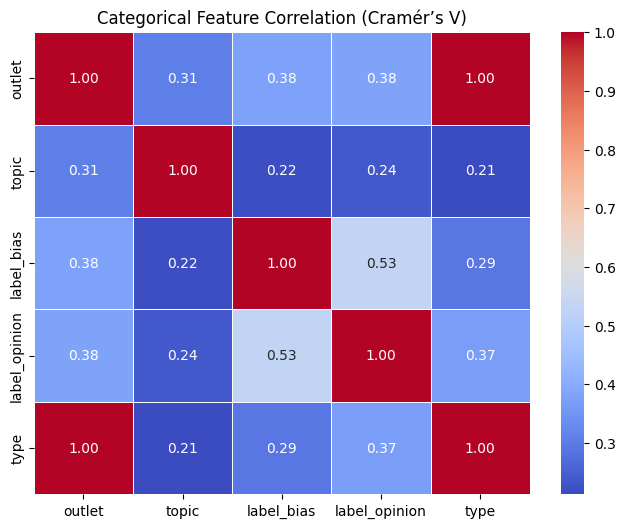

In [ ]:
import numpy as np
import scipy.stats as stats

def cramers_v(x, y):
    # A calculation of Cramer's V for categorical-categorical association
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def categorical_correlation(df, categorical_cols):
    # Calculate and plot categorical feature correlation
    cat_corr = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    for col1 in categorical_cols:
        for col2 in categorical_cols:
            if col1 == col2:
                cat_corr.loc[col1, col2] = 1.0
            else:
                cat_corr.loc[col1, col2] = cramers_v(df[col1], df[col2])
    cat_corr = cat_corr.astype(float)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cat_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Categorical Feature Correlation (Cramér’s V)")
    plt.show()

# Columns to correlate
categorical_cols = ["outlet", "topic", "label_bias", "label_opinion", "type"]
categorical_correlation(df, categorical_cols)

In [ ]:
# Fill missing values
df['news_link'] = df['news_link'].fillna('')  # Filling missing news_link with empty string

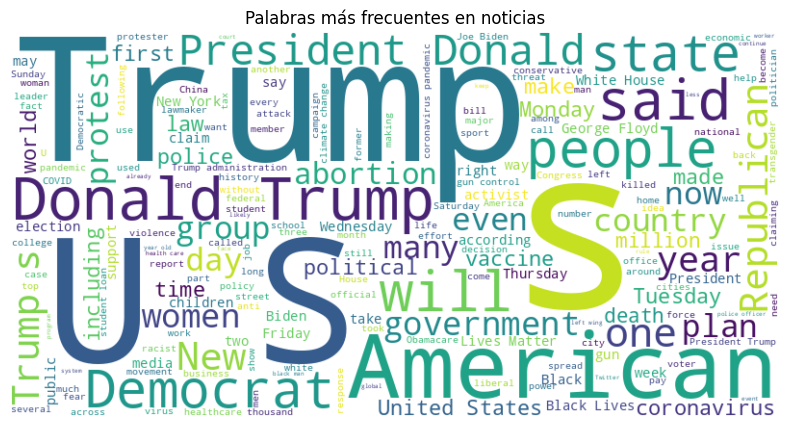

In [ ]:
from wordcloud import WordCloud

text_data = " ".join(df['text'].dropna())  # Combine all text into one string

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most frequent words in the articles")
plt.show()

In [ ]:
df_null_type = df[df['type'].isnull()]
df.dropna(subset=['type'], inplace=True)

X = df.drop(columns=['type'])
y = df['type']

categorical_cols = ['outlet', 'topic', 'label_bias', 'label_opinion']
text_cols = ['text']

# Preprocessing phase for the data, encoder and tfidvectorizer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('text', TfidfVectorizer(max_features=5000), 'text'),
    ]
)

# Model pipeline for RandomForestClassifier
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

C:\Users\petur\AppData\Local\Temp\ipykernel_14816\3129123980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['type'] = y_pred


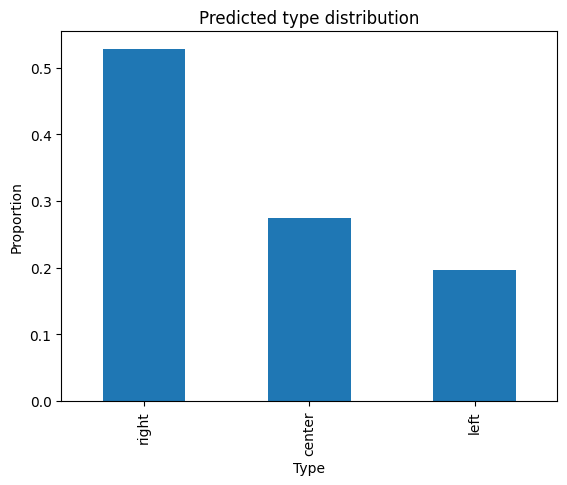

In [ ]:
# Predict on set df_null_type, the data with missing type
from matplotlib import pyplot as plt
y_pred = model.predict(df_null_type)
df_null_type['type'] = y_pred
df_null_type['type'].value_counts(normalize=True).plot(kind='bar')
plt.title('Predicted type distribution')
plt.xlabel('Type')
plt.ylabel('Proportion')
plt.show()

In [ ]:
complete_df = pd.concat([df, df_null_type])
complete_df.to_csv('data/final_labels_SG2.csv', index=False)